# Project

## Config

In [1]:
import os

# set up some configuration so that this notebook can be run easily locally or in a Google Colab Notebook (connected to Google Drive)
USE_GDRIVE = os.getenv('USE_GDRIVE', True),
RANDOM_STATE = 1001
PROJECT_DIR = os.getenv('PROJECT_DIR', os.path.join('drive', 'My Drive', 'ai-ml-challenge-2020'))

if USE_GDRIVE:
    from google.colab import drive
    drive.mount('/content/drive')

METRICS = {}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Setup

In [11]:
DATA_PATH = 'https://raw.githubusercontent.com/GSA/ai-ml-challenge-2020/master/'

In [12]:
# Get the data sets and split into train, dev, and validation

import pandas as pd
import numpy as np

# define text cleaning function
def preprocess_text(text):
    replace_chars = ['\n', '\t', '\r']
    for replace_char in replace_chars:
        text = text.replace(replace_char, ' ')
    return text

gold_data_path = os.path.join(DATA_PATH, 'data', 'AI_ML_Challenge_Training_Data_Set_1_v1.csv')
validation_data_path = os.path.join(DATA_PATH, 'data', 'AI_ML_Challenge_Validation_Data_Set_v1.csv')

gold_df = pd.read_csv(gold_data_path)
gold_df['text_cleaned'] = gold_df['Clause Text'].apply(preprocess_text)

train_df, dev_df, test_df = np.split(
    gold_df.sample(frac=1, random_state=RANDOM_STATE), 
    [int(.6*len(gold_df)), int(.8*len(gold_df))])

dev_df.head()

,Clause ID,Clause Text,Classification,text_cleaned
753,994,"1.1.18 “Warranty Service”, means the repair, r...",0,"1.1.18 “Warranty Service”, means the repair, r..."
5900,6889,Publicity. COMPANY may include Your name and l...,0,Publicity. COMPANY may include Your name and l...
6782,1224,10.5. Force Majeure. We and our affili...,1,10.5. Force Majeure. We and our affili...
1107,6195,MISCELLANEOUS. Any notice required or permitte...,0,MISCELLANEOUS. Any notice required or permitte...
2970,5870,Licensee acquires the right to use the Softwar...,0,Licensee acquires the right to use the Softwar...


## Metrics Setup

In [13]:
# define metrics function, also tracking precision and recall

from sklearn.metrics import f1_score, brier_score_loss, precision_score, recall_score

def gsa_metrics(y_true, y_pred, y_prob):
    return {
        'f1': f1_score(y_true, y_pred),
        'brier': brier_score_loss(y_true, y_prob),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

gsa_metrics(
    [0, 1, 0],
    [1, 1, 0],
    [0.77, 0.51, 0.2]
)

{'brier': 0.291, 'f1': 0.6666666666666666, 'precision': 0.5, 'recall': 1.0}

## Experiments

### Generate baseline metrics

Use very simple feature engineering and classification techniques to generate baseline metrics. These metrics will be useful for comparing against more novel classification methods.


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer(ngram_range=(2,8))
X_train_counts = count_vect.fit_transform(train_df.text_cleaned)
mnb_clf = MultinomialNB().fit(X_train_counts, train_df['Classification'])

In [6]:
X_test_counts = count_vect.transform(test_df.text_cleaned)
y_pred = mnb_clf.predict(X_test_counts)
y_prob = mnb_clf.predict_proba(X_test_counts).T[1]

In [7]:
mnb_metrics = gsa_metrics(test_df['Classification'], y_pred, y_prob)

METRICS['multinomial_naive_bayes'] = mnb_metrics

mnb_metrics

{'brier': 0.19262930241314086,
 'f1': 0.3476394849785408,
 'precision': 0.43315508021390375,
 'recall': 0.2903225806451613}

### Use a Transformer model

BERT and its family of Transformer models have revolutionized natural language processing due to their transfer learning capabilities. These models are pre-trained on large corpora of text on self-supervised tasks (usually the masked language model, or MLM), and then fine-tuned on a downstream task (e.g., classification, translation, question-answering, and named entity recognition).

Many pre-trained models are made publicly available, and are easy to instrument and run. This greatly decreases the cost to train and deploy domain-specific models, as all that is needed is a (relatively) small amount of training data for the fine-tuning task.

We're going to experiment with several of these models, using the `huggingface/transformers` library.

First, we're going to use DistilBERT, a version of BERT with nearly the same performance, but with much smaller weights.

In [8]:
!pip install transformers

     |████████████████████████████████| 778kB 6.4MB/s 
     |████████████████████████████████| 890kB 28.3MB/s 
     |████████████████████████████████| 3.0MB 19.4MB/s 
     |████████████████████████████████| 1.1MB 71.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=bbbdef805f042dca5a76d1d02850e13b6f5261a56770d6114ea46176d7bb31a3
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [14]:
import csv

# set up folders and data as TSVs in the CoLA format
distilbert_dir = os.path.join(PROJECT_DIR, 'submissions', 'distilbert')
distilbert_model_path = os.path.join(distilbert_dir, 'models')
os.makedirs(distilbert_dir, exist_ok=True)
os.makedirs(distilbert_model_path, exist_ok=True)


def convert_to_cola(df, max_len=512, no_labels=False):
    df = df.copy()
    df['source'] = 'gsa_ml_1'
    df['author_label'] = ''

    if no_labels:
        df = df[['source', 'author_label', 'text_cleaned']]
    else:
        df = df[['source', 'Classification', 'author_label', 'text_cleaned']]
    
    if no_labels:
        df.columns = ['source', 'author_label', 'text_a']
    else:
        df.columns = ['source', 'label', 'author_label', 'text_a']

    
    
    df['text_a'] = df.text_a.apply(preprocess_text)

    df['text_len'] = df.text_a.apply(lambda x: len(x))
    df = df[df.text_len > 12]

    if no_labels:
        df = df[['source', 'author_label', 'text_a']]
    else:
        df = df[['source', 'label', 'author_label', 'text_a']]
    
    df.text_a = df.text_a.apply(lambda x: x[:max_len].strip())

    return df

def df_to_tsv(df, outpath):
    df.to_csv(outpath, index=False, sep='\t', header=False, quoting=csv.QUOTE_NONE)

train_cola = convert_to_cola(train_df)
dev_cola = convert_to_cola(dev_df)
test_cola = convert_to_cola(test_df)

df_to_tsv(train_cola, os.path.join(distilbert_dir, 'train.tsv'))
df_to_tsv(dev_cola, os.path.join(distilbert_dir, 'dev.tsv'))
df_to_tsv(test_cola, os.path.join(distilbert_dir, 'test.tsv'))

dev_cola.head()

,source,label,author_label,text_a
753,gsa_ml_1,0,,"1.1.18 “Warranty Service”, means the repair, r..."
5900,gsa_ml_1,0,,Publicity. COMPANY may include Your name and l...
6782,gsa_ml_1,1,,10.5. Force Majeure. We and our affili...
1107,gsa_ml_1,0,,MISCELLANEOUS. Any notice required or permitte...
2970,gsa_ml_1,0,,Licensee acquires the right to use the Softwar...


In [15]:
import torch
from transformers import AutoModelForSequenceClassification

from tqdm.auto import tqdm
from tqdm import tqdm
tqdm.pandas()

def divide_chunks(l, n): 
    # looping till length l 
    for i in range(0, len(l), n):  
        yield l[i:i + n] 

def batch_predict(sequences, model):
    encoded = tokenizer.batch_encode_plus(sequences, return_tensors="pt", pad_to_max_length=True)
    logits = model(**encoded)[0]
    results = torch.softmax(logits, dim=1).tolist()
    probs = [r[1] for r in results]
    return probs


def predict(sequences, model):
    chunks = list(divide_chunks(sequences, 36))
    all_probs = []
    for chunk in tqdm(chunks):
        preds = batch_predict(chunk, model)
        for pred in preds:
            all_probs.append(pred)
    all_preds = [1 if prob > 0.5 else 0 for prob in all_probs]
    return all_probs, all_preds

def build_cola_trainer(model_name_or_path, output_dir, data_dir):
    import dataclasses
    import logging
    import os
    import sys
    from dataclasses import dataclass, field
    from typing import Dict, Optional

    import torch
    import numpy as np

    from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, GlueDataset
    from transformers import GlueDataTrainingArguments as DataTrainingArguments
    from transformers import (
        HfArgumentParser,
        Trainer,
        TrainingArguments,
        glue_compute_metrics,
        glue_output_modes,
        glue_tasks_num_labels,
        set_seed,
    )

    logging.basicConfig(level=logging.INFO)

    @dataclass
    class ModelArguments:
        """
        Arguments pertaining to which model/config/tokenizer we are going to fine-tune from.
        """

        model_name_or_path: str = field(
            metadata={"help": "Path to pretrained model or model identifier from huggingface.co/models"}
        )
        config_name: Optional[str] = field(
            default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
        )
        tokenizer_name: Optional[str] = field(
            default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
        )
        cache_dir: Optional[str] = field(
            default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
        )

    model_args = ModelArguments(
        model_name_or_path=model_name_or_path,
    )
    data_args = DataTrainingArguments(task_name="cola", data_dir=data_dir)
    training_args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        do_train=True,
        do_eval=False,
        per_gpu_train_batch_size=32,
        per_gpu_eval_batch_size=128,
        num_train_epochs=1,
        logging_steps=500,
        logging_first_step=True,
        save_steps=1000,
        evaluate_during_training=True,
    )
    set_seed(training_args.seed)
    num_labels = glue_tasks_num_labels[data_args.task_name]

    config = AutoConfig.from_pretrained(
        model_args.model_name_or_path,
        num_labels=num_labels,
        finetuning_task=data_args.task_name,
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args.model_name_or_path,
    )
    model = AutoModelForSequenceClassification.from_pretrained(
        model_args.model_name_or_path,
        config=config,
    )

    train_dataset = GlueDataset(data_args, tokenizer=tokenizer, limit_length=100_000)
    eval_dataset = GlueDataset(data_args, tokenizer=tokenizer, mode='dev')

    def compute_metrics(p: EvalPrediction) -> Dict:
        preds = np.argmax(p.predictions, axis=1)
        return glue_compute_metrics(data_args.task_name, preds, p.label_ids)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
    ) 
    return trainer, model, tokenizer

In [16]:
trainer, model, tokenizer = build_cola_trainer("distilbert-base-cased",
                            os.path.join(distilbert_model_path, 'distilbert-gsa-eula'),
                            distilbert_dir)


trainer.train()

model.save_pretrained(distilbert_model_path)
distilbert_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_path)
distilbert_model.eval()

y_prob, y_pred = predict(test_cola.text_a, distilbert_model)
distilbert_metrics = gsa_metrics(test_cola.label, y_pred, y_prob)

METRICS['distilbert'] = distilbert_metrics

distilbert_metrics

INFO:filelock:Lock 139792066962040 acquired on /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab97e2ee0f8d9071a5cd694e19bf664237a92aea20ebe04ddb7097b494.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-cased-config.json not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpaaw2ygz2


INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-cased-config.json in cache at /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab97e2ee0f8d9071a5cd694e19bf664237a92aea20ebe04ddb7097b494
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab97e2ee0f8d9071a5cd694e19bf664237a92aea20ebe04ddb7097b494
INFO:filelock:Lock 139792066962040 released on /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab97e2ee0f8d9071a5cd694e19bf664237a92aea20ebe04ddb7097b494.lock
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-cased-config.json from cache at /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab9

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-cased-config.json from cache at /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab97e2ee0f8d9071a5cd694e19bf664237a92aea20ebe04ddb7097b494
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 28996
}

INFO:filelock:Lock 139792019372576 acquired on /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f635

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt in cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1
INFO:filelock:Lock 139792019372576 released on /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1.lock
INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.cache/torch/transformers/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f2

INFO:filelock:Lock 139792402087720 acquired on /root/.cache/torch/transformers/185eb053d63bc5c2d6994e4b2a8e5eb59f31af90db9c5fae5e38c32a986462cb.857b7d17ad0bfaa2eec50caf481575bab1073303fef16bd5f29bc5248b2b8c7d.lock
INFO:transformers.file_utils:https://cdn.huggingface.co/distilbert-base-cased-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpuvahlqke


INFO:transformers.file_utils:storing https://cdn.huggingface.co/distilbert-base-cased-pytorch_model.bin in cache at /root/.cache/torch/transformers/185eb053d63bc5c2d6994e4b2a8e5eb59f31af90db9c5fae5e38c32a986462cb.857b7d17ad0bfaa2eec50caf481575bab1073303fef16bd5f29bc5248b2b8c7d
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/185eb053d63bc5c2d6994e4b2a8e5eb59f31af90db9c5fae5e38c32a986462cb.857b7d17ad0bfaa2eec50caf481575bab1073303fef16bd5f29bc5248b2b8c7d
INFO:filelock:Lock 139792402087720 released on /root/.cache/torch/transformers/185eb053d63bc5c2d6994e4b2a8e5eb59f31af90db9c5fae5e38c32a986462cb.857b7d17ad0bfaa2eec50caf481575bab1073303fef16bd5f29bc5248b2b8c7d.lock
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/distilbert-base-cased-pytorch_model.bin from cache at /root/.cache/torch/transformers/185eb053d63bc5c2d6994e4b2a8e5eb59f31af90db9c5fae5e38c32a986462cb.857b7d17ad0bfaa2eec50caf481575bab1073303fef16bd5f29bc5248b

- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:filelock:Lock 139791959022728 acquired on drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/cached_train_DistilBertTokenizer_128_cola.lock
INFO:transformers.data.datasets.glue:Loading features from cached file drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/cached_train_DistilBertTokenizer_128_cola [took 0.416 s]
INFO:filelock:Lock 139791959022728 released 

INFO:transformers.trainer:{'loss': 0.0012767165899276733, 'learning_rate': 4.9647887323943665e-05, 'epoch': 0.007042253521126761, 'step': 1}
INFO:transformers.trainer:

Training completed. Do not forget to share your model on huggingface.co/models =)




INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/pytorch_model.bin
INFO:transformers.configuration_utils:loading configuration file drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "cola",
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 28996
}

I

{'brier': 0.10805336113651824,
 'f1': 0.5077951002227171,
 'precision': 0.6705882352941176,
 'recall': 0.40860215053763443}

#### Pre-training

Next, we'll try the same DistilBERT model, but before we fine-tune it, we will pre-train it on a corpus of End User License agreements that were collected from around the web.

In [17]:
eula_raw_path = os.path.join(PROJECT_DIR, 'submissions', 'eula_raw.txt')
eula_raw_lines = open(eula_raw_path, 'r').readlines()
eula_raw_lines[10:12]

['1. GRANT OF LICENSE.\n',
 '1.1 UBISOFT (or its licensors) grants You a non-exclusive, non-transferable, non-sublicensed, non-commercial and personal license to install and/or use the Product (in whole or in part) and any Product (the “License”), for such time until either You or UBISOFT terminates this EULA. You must in no event use, nor allow others to use,the Product or this License for commercial purposes without obtaining a license to do so from UBISOFT. Updates, upgrades, patches and modifications may be necessary in order to be able to continue to use the Product on certain hardware. THIS PRODUCT IS LICENSED TO YOU, NOT SOLD.\n']

In [18]:
import nltk
nltk.download('punkt')

from nltk.tokenize import sent_tokenize

eula_sentences = []
for line in eula_raw_lines:
    for sent in sent_tokenize(line):
        eula_sentences.append(sent)
len(eula_sentences)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


12533

In [19]:
# split sentences into train and test files

num_sents = len(eula_sentences)
cutoff = int(num_sents * 0.8)
train_sents = eula_sentences[:cutoff]
test_sents = eula_sentences[cutoff:]

print(len(train_sents), len(test_sents))

eula_train_path = os.path.join(PROJECT_DIR, 'submissions', 'eula_train.txt')
with open(eula_train_path, 'w') as file:
    file.write("\n".join(train_sents))

eula_test_path = os.path.join(PROJECT_DIR, 'submissions', 'eula_test.txt')
with open(eula_test_path, 'w') as file:
    file.write("\n".join(test_sents))

10026 2507


In [20]:
def pretrain(model_name_or_path, output_dir, train_path, test_path):
    import logging
    import math
    import os
    from dataclasses import dataclass, field
    from typing import Optional

    from transformers import (
        CONFIG_MAPPING,
        MODEL_WITH_LM_HEAD_MAPPING,
        AutoConfig,
        AutoModelWithLMHead,
        AutoTokenizer,
        DataCollatorForLanguageModeling,
        HfArgumentParser,
        LineByLineTextDataset,
        PreTrainedTokenizer,
        TextDataset,
        Trainer,
        TrainingArguments,
        set_seed,
    )


    logger = logging.getLogger(__name__)


    MODEL_CONFIG_CLASSES = list(MODEL_WITH_LM_HEAD_MAPPING.keys())
    MODEL_TYPES = tuple(conf.model_type for conf in MODEL_CONFIG_CLASSES)


    @dataclass
    class ModelArguments:
        """
        Arguments pertaining to which model/config/tokenizer we are going to fine-tune, or train from scratch.
        """

        model_name_or_path: Optional[str] = field(
            default=None,
            metadata={
                "help": "The model checkpoint for weights initialization. Leave None if you want to train a model from scratch."
            },
        )
        model_type: Optional[str] = field(
            default=None,
            metadata={"help": "If training from scratch, pass a model type from the list: " + ", ".join(MODEL_TYPES)},
        )
        config_name: Optional[str] = field(
            default=None, metadata={"help": "Pretrained config name or path if not the same as model_name"}
        )
        tokenizer_name: Optional[str] = field(
            default=None, metadata={"help": "Pretrained tokenizer name or path if not the same as model_name"}
        )
        cache_dir: Optional[str] = field(
            default=None, metadata={"help": "Where do you want to store the pretrained models downloaded from s3"}
        )


    @dataclass
    class DataTrainingArguments:
        """
        Arguments pertaining to what data we are going to input our model for training and eval.
        """

        train_data_file: Optional[str] = field(
            default=None, metadata={"help": "The input training data file (a text file)."}
        )
        eval_data_file: Optional[str] = field(
            default=None,
            metadata={"help": "An optional input evaluation data file to evaluate the perplexity on (a text file)."},
        )
        line_by_line: bool = field(
            default=False,
            metadata={"help": "Whether distinct lines of text in the dataset are to be handled as distinct sequences."},
        )

        mlm: bool = field(
            default=False, metadata={"help": "Train with masked-language modeling loss instead of language modeling."}
        )
        mlm_probability: float = field(
            default=0.15, metadata={"help": "Ratio of tokens to mask for masked language modeling loss"}
        )
        plm_probability: float = field(
            default=1 / 6,
            metadata={
                "help": "Ratio of length of a span of masked tokens to surrounding context length for permutation language modeling."
            },
        )
        max_span_length: int = field(
            default=5, metadata={"help": "Maximum length of a span of masked tokens for permutation language modeling."}
        )

        block_size: int = field(
            default=-1,
            metadata={
                "help": "Optional input sequence length after tokenization."
                "The training dataset will be truncated in block of this size for training."
                "Default to the model max input length for single sentence inputs (take into account special tokens)."
            },
        )
        overwrite_cache: bool = field(
            default=False, metadata={"help": "Overwrite the cached training and evaluation sets"}
        )


    def get_dataset(args: DataTrainingArguments, tokenizer: PreTrainedTokenizer, evaluate=False):
        file_path = args.eval_data_file if evaluate else args.train_data_file
        if args.line_by_line:
            return LineByLineTextDataset(tokenizer=tokenizer, file_path=file_path, block_size=args.block_size)
        else:
            return TextDataset(
                tokenizer=tokenizer, file_path=file_path, block_size=args.block_size, overwrite_cache=args.overwrite_cache
            )

    model_args = ModelArguments(
        model_type='distilbert',
        model_name_or_path=model_name_or_path
        #model_name_or_path='distilbert-base-cased'
    )
    data_args = DataTrainingArguments(
        # train_data_file=eula_train_path,
        # eval_data_file=eula_test_path,
        train_data_file=train_path,
        eval_data_file=test_path,
        line_by_line=True,
        mlm=True
    )

    # distilbert_gsa_eula_pretrained_path = os.path.join(distilbert_model_path, 'distilbert_gsa_eula_pretrained')
    # distilbert_gsa_eula_pretrained_path = os.path.join(distilbert_model_path, 'distilbert_gsa_eula_pretrained')
    training_args = TrainingArguments(
        #output_dir=distilbert_gsa_eula_pretrained_path,
        output_dir=output_dir,
        do_train=True,
        do_eval=False,
        overwrite_output_dir=True
    )

    # See all possible arguments in src/transformers/training_args.py
    # or by passing the --help flag to this script.
    # We now keep distinct sets of args, for a cleaner separation of concerns.

    # parser = HfArgumentParser((ModelArguments, DataTrainingArguments, TrainingArguments))
    # model_args, data_args, training_args = parser.parse_args_into_dataclasses()

    if data_args.eval_data_file is None and training_args.do_eval:
        raise ValueError(
            "Cannot do evaluation without an evaluation data file. Either supply a file to --eval_data_file "
            "or remove the --do_eval argument."
        )

    if (
        os.path.exists(training_args.output_dir)
        and os.listdir(training_args.output_dir)
        and training_args.do_train
        and not training_args.overwrite_output_dir
    ):
        raise ValueError(
            f"Output directory ({training_args.output_dir}) already exists and is not empty. Use --overwrite_output_dir to overcome."
        )

    # Setup logging
    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO if training_args.local_rank in [-1, 0] else logging.WARN,
    )
    logger.warning(
        "Process rank: %s, device: %s, n_gpu: %s, distributed training: %s, 16-bits training: %s",
        training_args.local_rank,
        training_args.device,
        training_args.n_gpu,
        bool(training_args.local_rank != -1),
        training_args.fp16,
    )
    logger.info("Training/evaluation parameters %s", training_args)

    # Set seed
    set_seed(training_args.seed)

    # Load pretrained model and tokenizer
    #
    # Distributed training:
    # The .from_pretrained methods guarantee that only one local process can concurrently
    # download model & vocab.

    if model_args.config_name:
        config = AutoConfig.from_pretrained(model_args.config_name, cache_dir=model_args.cache_dir)
    elif model_args.model_name_or_path:
        config = AutoConfig.from_pretrained(model_args.model_name_or_path, cache_dir=model_args.cache_dir)
    else:
        config = CONFIG_MAPPING[model_args.model_type]()
        logger.warning("You are instantiating a new config instance from scratch.")

    if model_args.tokenizer_name:
        tokenizer = AutoTokenizer.from_pretrained(model_args.tokenizer_name, cache_dir=model_args.cache_dir)
    elif model_args.model_name_or_path:
        tokenizer = AutoTokenizer.from_pretrained(model_args.model_name_or_path, cache_dir=model_args.cache_dir)
    else:
        raise ValueError(
            "You are instantiating a new tokenizer from scratch. This is not supported, but you can do it from another script, save it,"
            "and load it from here, using --tokenizer_name"
        )

    if model_args.model_name_or_path:
        model = AutoModelWithLMHead.from_pretrained(
            model_args.model_name_or_path,
            from_tf=bool(".ckpt" in model_args.model_name_or_path),
            config=config,
            cache_dir=model_args.cache_dir,
        )
    else:
        logger.info("Training new model from scratch")
        model = AutoModelWithLMHead.from_config(config)

    model.resize_token_embeddings(len(tokenizer))

    if config.model_type in ["bert", "roberta", "distilbert", "camembert"] and not data_args.mlm:
        raise ValueError(
            "BERT and RoBERTa-like models do not have LM heads but masked LM heads. They must be run using the"
            "--mlm flag (masked language modeling)."
        )

    if data_args.block_size <= 0:
        data_args.block_size = tokenizer.max_len
        # Our input block size will be the max possible for the model
    else:
        data_args.block_size = min(data_args.block_size, tokenizer.max_len)

    # Get datasets

    train_dataset = get_dataset(data_args, tokenizer=tokenizer) if training_args.do_train else None
    eval_dataset = get_dataset(data_args, tokenizer=tokenizer, evaluate=True) if training_args.do_eval else None
    if config.model_type == "xlnet":
        # data_collator = DataCollatorForPermutationLanguageModeling(
        #     tokenizer=tokenizer, plm_probability=data_args.plm_probability, max_span_length=data_args.max_span_length,
        # )
        raise Exception("Can't use xlnet")
    else:
        data_collator = DataCollatorForLanguageModeling(
            tokenizer=tokenizer, mlm=data_args.mlm, mlm_probability=data_args.mlm_probability
        )

    # Initialize our Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        data_collator=data_collator,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        prediction_loss_only=True,
    )

    # Training
    if training_args.do_train:
        model_path = (
            model_args.model_name_or_path
            if model_args.model_name_or_path is not None and os.path.isdir(model_args.model_name_or_path)
            else None
        )
        trainer.train(model_path=model_path)
        trainer.save_model()
        # For convenience, we also re-save the tokenizer to the same directory,
        # so that you can share your model easily on huggingface.co/models =)
        if trainer.is_world_master():
            tokenizer.save_pretrained(training_args.output_dir)

    # Evaluation
    results = {}
    if training_args.do_eval:
        logger.info("*** Evaluate ***")

        eval_output = trainer.evaluate()

        perplexity = math.exp(eval_output["eval_loss"])
        result = {"perplexity": perplexity}

        output_eval_file = os.path.join(training_args.output_dir, "eval_results_lm.txt")
        if trainer.is_world_master():
            with open(output_eval_file, "w") as writer:
                logger.info("***** Eval results *****")
                for key in sorted(result.keys()):
                    logger.info("  %s = %s", key, str(result[key]))
                    writer.write("%s = %s\n" % (key, str(result[key])))

        results.update(result)

    return results

In [21]:
output_dir = distilbert_gsa_eula_pretrained_path = os.path.join(distilbert_model_path, 'distilbert_gsa_eula_pretrained')
out = pretrain('distilbert-base-cased', output_dir, eula_train_path, eula_test_path)

INFO:transformers.training_args:PyTorch: setting up devices
INFO:__main__:Training/evaluation parameters TrainingArguments(output_dir='drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained', overwrite_output_dir=True, do_train=True, do_eval=False, do_predict=False, evaluate_during_training=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, learning_rate=5e-05, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, warmup_steps=0, logging_dir='runs/Aug20_12-38-17_db44b6159314', logging_first_step=False, logging_steps=500, save_steps=500, save_total_limit=None, no_cuda=False, seed=42, fp16=False, fp16_opt_level='O1', local_rank=-1, tpu_num_cores=None, tpu_metrics_debug=False, debug=False, dataloader_drop_last=False, eval_steps=1000, past_index=-1)
INFO:transformers.configuration_utils:loading configur

INFO:transformers.trainer:{'loss': 2.4974203392267227, 'learning_rate': 4.335459861775651e-05, 'epoch': 0.39872408293460926, 'step': 500}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-500
INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-500/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
INFO:transformers.trainer:{'loss': 2.1244906730651856, 'learning_rate': 3.670919723551303e-05, 'epoch':

INFO:transformers.trainer:{'loss': 1.8832420311570168, 'learning_rate': 3.0063795853269537e-05, 'epoch': 1.1961722488038278, 'step': 1500}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-1500
INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-1500/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-1500/pytorch_model.bin
INFO:transformers.trainer:{'loss': 1.7559279701709747, 'learning_rate': 2.341839447102605e-05, 'epoch': 1.594896331738437, 'step': 2000}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-2000
INFO:transformers.c

INFO:transformers.trainer:{'loss': 1.5240204479396344, 'learning_rate': 1.0127591706539077e-05, 'epoch': 2.3923444976076556, 'step': 3000}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-3000
INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-3000/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-3000/pytorch_model.bin
INFO:transformers.trainer:{'loss': 1.5376053354963661, 'learning_rate': 3.4821903242955873e-06, 'epoch': 2.7910685805422646, 'step': 3500}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/checkpoint-3500
INFO:transformers

INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/pytorch_model.bin


Before we fine-tune the newly-pre-trained model, let's check to see if the underlying language model learned how to predict the next word in a EULA.

In [22]:
from operator import itemgetter

from transformers import pipeline

fill_mask_plain = pipeline(
    "fill-mask",
    model="distilbert-base-cased",
    tokenizer="distilbert-base-cased"
)

fill_mask_eula = pipeline(
    "fill-mask",
    model=distilbert_gsa_eula_pretrained_path,
    tokenizer=distilbert_gsa_eula_pretrained_path
)


sentences = [
    "This EULA is effective until [MASK]",
    "This agreement shall be governed by the laws of [MASK]",
    "Our products may contain errors and other [MASK]",
    "Limited [MASK] and Disclaimer",
    "If a party materially [MASK] this EULA",
    "Confidential [MASK] and Data"
]

for sentence in sentences:
    print(sentence)
    plain_pred = list(map(itemgetter('token_str'), fill_mask_plain(sentence)))
    eula_pred = list(map(itemgetter('token_str'), fill_mask_eula(sentence)))
    print("\t- Without EULA pre-training:", plain_pred)
    print("\t- With EULA pre-training:", eula_pred)
    print()

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-cased-config.json from cache at /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab97e2ee0f8d9071a5cd694e19bf664237a92aea20ebe04ddb7097b494
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 28996
}

INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at /root/.cache/torch/transformers/5e8a2b4893d137

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-cased-modelcard.json in cache at /root/.cache/torch/transformers/e7d48e6fc39207404b4bb02c7e5b18c589596b890807864fe4b46fcd88e54e28.455d944f3d1572ab55ed579849f751cf37f303e3388980a42d94f7cd57a4e331
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/e7d48e6fc39207404b4bb02c7e5b18c589596b890807864fe4b46fcd88e54e28.455d944f3d1572ab55ed579849f751cf37f303e3388980a42d94f7cd57a4e331
INFO:filelock:Lock 139785467024944 released on /root/.cache/torch/transformers/e7d48e6fc39207404b4bb02c7e5b18c589596b890807864fe4b46fcd88e54e28.455d944f3d1572ab55ed579849f751cf37f303e3388980a42d94f7cd57a4e331.lock
INFO:transformers.modelcard:loading model card file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-cased-modelcard.json from cache at /root/.cache/torch/transformers/e7d48e6fc39207404b4bb02c7e5b18c589596b890807864fe4b46fcd88e54e28.455d944f3d1572ab

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:798: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,
INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/distilbert-base-cased-config.json from cache at /root/.cache/torch/transformers/774d52b0be7c2f621ac9e64708a8b80f22059f6d0e264e1bdc4f4d71c386c4ea.f44aaaab97e2ee0f8d9071a5cd694e19bf664237a92aea20ebe04ddb7097b494
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output

This EULA is effective until [MASK]
	- Without EULA pre-training: ['2020', '.', '2019', ';', ':']
	- With EULA pre-training: ['the', '2020', 'terminated', 'this', 'termination']

This agreement shall be governed by the laws of [MASK]
	- Without EULA pre-training: [':', 'parliament', 'justice', ';', 'congress']
	- With EULA pre-training: ['the', 'Brazil', 'California', 'Europe', 'this']

Our products may contain errors and other [MASK]
	- Without EULA pre-training: ['errors', 'defects', 'problems', 'flaws', 'factors']
	- With EULA pre-training: ['defects', 'software', 'information', 'errors', 'viruses']

Limited [MASK] and Disclaimer
	- Without EULA pre-training: ['citation', 'notes', 'score', 'summary', 'certificate']
	- With EULA pre-training: ['License', 'Order', 'Edition', 'Release', 'Distribution']

If a party materially [MASK] this EULA
	- Without EULA pre-training: ['supports', 'rejects', 'accepts', 'violated', 'gains']
	- With EULA pre-training: ['makes', 'accepts', 'violated', 

With this casual peek inside the newly-pretrained language model, it appears that the model is able to predict the masked word in the EULA text domain better than the off-the-shelf DistilBERT model.

Next, we'll fine-tune the EULA-pretrained model.

In [23]:
# output_dir is the output directory from the prior pre-training stage.
# we'll use the pre-trained model saved their as the base model to fine-tune
trainer, model, tokenizer = build_cola_trainer(
                                output_dir,
                                os.path.join(distilbert_model_path, 'distilbert-gsa-eula-pretrained-and-finetuned'),
                                distilbert_dir)



trainer.train()

model.save_pretrained(os.path.join(distilbert_model_path, 'distilbert-gsa-eula-pretrained-and-finetuned'))
distilbert_eula_model = AutoModelForSequenceClassification.from_pretrained(os.path.join(distilbert_model_path, 'distilbert-gsa-eula-pretrained-and-finetuned'))
distilbert_eula_model.eval()

y_prob, y_pred = predict(test_cola.text_a, distilbert_eula_model)
 

METRICS['distilbert_eula'] = gsa_metrics(test_cola.label, y_pred, y_prob)
METRICS['distilbert_eula']

INFO:transformers.configuration_utils:loading configuration file drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "cola",
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 28996
}

INFO:transformers.configuration_utils:loading configuration file drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_pretrained/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "ge

INFO:transformers.trainer:{'loss': 0.001295229196548462, 'learning_rate': 4.9647887323943665e-05, 'epoch': 0.007042253521126761, 'step': 1}
INFO:transformers.trainer:

Training completed. Do not forget to share your model on huggingface.co/models =)




INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert-gsa-eula-pretrained-and-finetuned/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert-gsa-eula-pretrained-and-finetuned/pytorch_model.bin
INFO:transformers.configuration_utils:loading configuration file drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert-gsa-eula-pretrained-and-finetuned/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "cola",
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,

{'brier': 0.10655712056049071,
 'f1': 0.5182186234817814,
 'precision': 0.5953488372093023,
 'recall': 0.45878136200716846}



Next, we'll pre-train on the OPP-115 data set, which includes a compilation of dozens of privacy policies. While the submission does not include all the files of OPP-115, they can be downloaded here: https://usableprivacy.org/static/data/OPP-115_v1_0.zip 

#### Pre-training on additional text

In [24]:
opp_115_path = os.path.join(PROJECT_DIR, 'submissions', 'OPP-115')

In [25]:
from bs4 import BeautifulSoup

opp_files = os.listdir(opp_115_path)

opp_files[0:10]

['995_mohegansun.com.html',
 '98_neworleansonline.com.html',
 '988_solarviews.com.html',
 '962_lynda.com.html',
 '940_internetbrands.com.html',
 '93_pbs.org.html',
 '898_uptodate.com.html',
 '919_uh.edu.html',
 '884_naturalnews.com.html',
 '883_ted.com.html']

In [26]:
opp_texts = []

for opp_file in tqdm(opp_files):
    path = os.path.join(opp_115_path, opp_file)
    html = open(path, 'r')
    soup = BeautifulSoup(html, 'html.parser')
    text = soup.text
    opp_texts.append(text)

opp_texts[5][0:200]

100%|██████████| 115/115 [00:42<00:00,  2.68it/s]


'Privacy Policy  |||PBS is committed to protecting the private information of our web site visitors. From the pbs.org homepage to more than 150,000 pages of content produced by our affiliates, the "pbs'

In [27]:
opp_eula_sentences = []
for doc in tqdm(opp_texts):
    for sent in sent_tokenize(doc):
        opp_eula_sentences.append(sent)

len(opp_eula_sentences)

100%|██████████| 115/115 [00:00<00:00, 332.15it/s]


10580

In [28]:
# combine that with the eula_raw.txt contents
eula_opp_sents = opp_eula_sentences + eula_sentences

# shuffle them
import random
random.seed(RANDOM_STATE)

random.shuffle(eula_opp_sents)

len(eula_opp_sents)

23113

In [29]:
# split sentences into train and test files

num_sents = len(eula_opp_sents)
cutoff = int(num_sents * 0.8)
train_sents = eula_opp_sents[:cutoff]
test_sents = eula_opp_sents[cutoff:]

print(len(train_sents), len(test_sents))

eula_opp_train_path = os.path.join(PROJECT_DIR, 'submissions', 'eula_opp_train.txt')
with open(eula_opp_train_path, 'w') as file:
    file.write("\n".join(train_sents))

eula_opp_test_path = os.path.join(PROJECT_DIR, 'submissions', 'eula_opp_test.txt')
with open(eula_opp_test_path, 'w') as file:
    file.write("\n".join(test_sents))

18490 4623


Now we have almost doubled the number of sentences to pre-train with. Let's pre-train again.

In [30]:
# out = pretrain(model_args, data_args, training_args)
output_dir = os.path.join(distilbert_model_path, 'distilbert_gsa_eula_opp_pretrained')
out = pretrain('distilbert-base-cased', output_dir, eula_opp_train_path, eula_opp_test_path)

INFO:transformers.training_args:PyTorch: setting up devices
INFO:__main__:Training/evaluation parameters TrainingArguments(output_dir='drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained', overwrite_output_dir=True, do_train=True, do_eval=False, do_predict=False, evaluate_during_training=False, per_device_train_batch_size=8, per_device_eval_batch_size=8, per_gpu_train_batch_size=None, per_gpu_eval_batch_size=None, gradient_accumulation_steps=1, learning_rate=5e-05, weight_decay=0.0, adam_epsilon=1e-08, max_grad_norm=1.0, num_train_epochs=3.0, max_steps=-1, warmup_steps=0, logging_dir='runs/Aug20_12-49-37_db44b6159314', logging_first_step=False, logging_steps=500, save_steps=500, save_total_limit=None, no_cuda=False, seed=42, fp16=False, fp16_opt_level='O1', local_rank=-1, tpu_num_cores=None, tpu_metrics_debug=False, debug=False, dataloader_drop_last=False, eval_steps=1000, past_index=-1)
INFO:transformers.configuration_utils:loading conf

INFO:transformers.trainer:{'loss': 2.5124690455198286, 'learning_rate': 4.639561707035756e-05, 'epoch': 0.21626297577854672, 'step': 500}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-500
INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-500/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-500/pytorch_model.bin
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)
INFO:transformers.trainer:{'loss': 2.214979897618294, 'learning_rate': 4.2791234140715114e-

INFO:transformers.trainer:{'loss': 1.8615564662814141, 'learning_rate': 3.1978085351787776e-05, 'epoch': 1.0813148788927336, 'step': 2500}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-2500
INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-2500/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-2500/pytorch_model.bin
INFO:transformers.trainer:{'loss': 1.7973864872455596, 'learning_rate': 2.8373702422145332e-05, 'epoch': 1.2975778546712804, 'step': 3000}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-3000
I

INFO:transformers.trainer:{'loss': 1.5782592906355857, 'learning_rate': 1.395617070357555e-05, 'epoch': 2.162629757785467, 'step': 5000}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-5000
INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-5000/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-5000/pytorch_model.bin
INFO:transformers.trainer:{'loss': 1.514185332775116, 'learning_rate': 1.0351787773933102e-05, 'epoch': 2.378892733564014, 'step': 5500}
INFO:transformers.trainer:Saving model checkpoint to drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/checkpoint-5500
INFO:

INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/config.json
INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/pytorch_model.bin


Let's do the same fill-mask comparison:

In [31]:
fill_mask_opp_eula = pipeline(
    "fill-mask",
    model=output_dir,
    tokenizer=output_dir
)

INFO:transformers.configuration_utils:loading configuration file drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 28996
}

INFO:transformers.tokenization_utils_base:Model name 'drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained' not found in model shortcut name list (distilbert-base-uncased, distilbert-base-uncased-distilled-squad, distilbert-base-cased, dist

In [32]:
sentences = [
    "This EULA is effective until [MASK]",
    "This agreement shall be governed by the laws of [MASK]",
    "Our products may contain errors and other [MASK]",
    "Limited [MASK] and Disclaimer",
    "If a party materially [MASK] this EULA",
    "Confidential [MASK] and Data"
]

for sentence in sentences:
    print(sentence)
    plain_pred = list(map(itemgetter('token_str'), fill_mask_plain(sentence)))
    eula_pred = list(map(itemgetter('token_str'), fill_mask_eula(sentence)))
    eula_opp_pred = list(map(itemgetter('token_str'), fill_mask_opp_eula(sentence)))
    print("\t- Without EULA or OPP pre-training:", plain_pred)
    print("\t- With EULA pre-training:", eula_pred)
    print("\t- With EULA and OPP pre-trining", eula_opp_pred)
    print()

This EULA is effective until [MASK]
	- Without EULA or OPP pre-training: ['2020', '.', '2019', ';', ':']
	- With EULA pre-training: ['the', '2020', 'terminated', 'this', 'termination']
	- With EULA and OPP pre-trining ['2020', 'the', ':', '.', 'termination']

This agreement shall be governed by the laws of [MASK]
	- Without EULA or OPP pre-training: [':', 'parliament', 'justice', ';', 'congress']
	- With EULA pre-training: ['the', 'Brazil', 'California', 'Europe', 'this']
	- With EULA and OPP pre-trining ['California', 'America', 'Ireland', 'England', 'Utah']

Our products may contain errors and other [MASK]
	- Without EULA or OPP pre-training: ['errors', 'defects', 'problems', 'flaws', 'factors']
	- With EULA pre-training: ['defects', 'software', 'information', 'errors', 'viruses']
	- With EULA and OPP pre-trining ['errors', 'defects', 'information', 'data', 'problems']

Limited [MASK] and Disclaimer
	- Without EULA or OPP pre-training: ['citation', 'notes', 'score', 'summary', 'certi

In [33]:
# output_dir is the output directory from the prior pre-training stage.
# we'll use the pre-trained model saved their as the base model to fine-tune
distilbert_eula_opp_model_path = os.path.join(distilbert_model_path, 'distilbert-gsa-eula-opp-pretrained-and-finetuned')

trainer, model, tokenizer = build_cola_trainer(
                                output_dir,
                                distilbert_eula_opp_model_path,
                                distilbert_dir)



trainer.train()
model.save_pretrained(distilbert_eula_opp_model_path)
distilbert_eula_opp_model = AutoModelForSequenceClassification.from_pretrained(distilbert_eula_opp_model_path)
distilbert_eula_opp_model.eval()
y_prob, y_pred = predict(test_cola.text_a, distilbert_eula_opp_model)

METRICS['distilbert_eula_opp_model'] = gsa_metrics(test_cola.label, y_pred, y_prob)
METRICS['distilbert_eula_opp_model']

INFO:transformers.configuration_utils:loading configuration file drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "cola",
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 28996
}

INFO:transformers.configuration_utils:loading configuration file drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert_gsa_eula_opp_pretrained/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activati

INFO:transformers.trainer:{'loss': 0.001289313554763794, 'learning_rate': 4.9647887323943665e-05, 'epoch': 0.007042253521126761, 'step': 1}
INFO:transformers.trainer:

Training completed. Do not forget to share your model on huggingface.co/models =)


INFO:transformers.configuration_utils:Configuration saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert-gsa-eula-opp-pretrained-and-finetuned/config.json


INFO:transformers.modeling_utils:Model weights saved in drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert-gsa-eula-opp-pretrained-and-finetuned/pytorch_model.bin
INFO:transformers.configuration_utils:loading configuration file drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert-gsa-eula-opp-pretrained-and-finetuned/config.json
INFO:transformers.configuration_utils:Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "cola",
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "vocab_size": 28996
}

INFO:transformers.modeling_utils:loading w

{'brier': 0.10272874882431418,
 'f1': 0.5436105476673428,
 'precision': 0.6261682242990654,
 'recall': 0.48028673835125446}

In [49]:
# save the tokenizer
tokenizer.save_pretrained(distilbert_eula_opp_model_path)

('drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert-gsa-eula-opp-pretrained-and-finetuned/vocab.txt',
 'drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert-gsa-eula-opp-pretrained-and-finetuned/special_tokens_map.json',
 'drive/My Drive/ai-ml-challenge-2020/submissions/distilbert/models/distilbert-gsa-eula-opp-pretrained-and-finetuned/added_tokens.json')

## Conclusion

### Table of Results

In [34]:
results_df = pd.DataFrame(METRICS).T
results_df

,f1,brier,precision,recall
multinomial_naive_bayes,0.347639,0.192629,0.433155,0.290323
distilbert,0.507795,0.108053,0.670588,0.408602
distilbert_eula,0.518219,0.106557,0.595349,0.458781
distilbert_eula_opp_model,0.543611,0.102729,0.626168,0.480287


From these results, we can see progressive improvement on each iteration. The model that performed best under the f1 and Brier loss metrics was the `distilbert_eula_opp_model`, which was had additional pre-training on EULAs from around the web, on the OPP-115 privacy policy data set, and then fine-tuned on GSA's EULA acceptance data set.

### Explainability

While deep neural networks have been very accurate at text classification, their predictions are far less explainable than some of the more traditional approaches such as Naive Bayes. However, there are a range of tools that have been developed to evaluate black box models. One such tool is called [`lime`](https://github.com/marcotcr/lime).

Lime conducts experiments on an input text and a model. It generates different combinations of modifications of the input text (e.g. by removing a word) and compares how those modifications impact the final score from the model.

With these comparisons, Lime is then able to provide data (or a data visualization) showing a hypothesis for which words or phrases impacted the score the most. 

Below is a function that uses Lime and the `distilbert_eula_opp_model` to provide an explanation for any prediction that the model makes.

In [ ]:
!pip install lime

In [36]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['not_acceptable', 'acceptable'])

def lime_predict(sequences):
    encoded = tokenizer.batch_encode_plus(sequences, return_tensors="pt", pad_to_max_length=True)
    logits = distilbert_eula_opp_model(**encoded)[0]
    results = torch.softmax(logits, dim=1).tolist()
    return np.array(results)

def lime_explainer(input_sequence, num_features=10, num_samples=100):
    exp = explainer.explain_instance(input_sequence, lime_predict, num_features=num_features, num_samples=num_samples)
    return exp

/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]


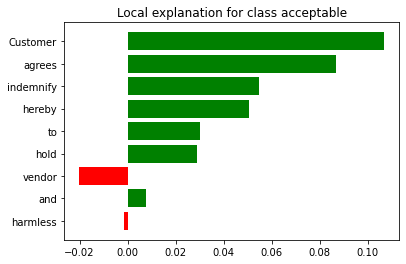

In [52]:
%matplotlib inline

exp = lime_explainer("Customer hereby agrees to indemnify and hold vendor harmless.")
fig = exp.as_pyplot_figure()

### Validation file results

Finally, below are the results of running the `distilbert_eula_opp_model` against the validation file provided by GSA.

In [72]:
validation_df = pd.read_csv(validation_data_path)
print("rows before filtering:", len(validation_df))

validation_df['text_cleaned'] = validation_df['Clause Text'].apply(preprocess_text)

validation_df['text_len'] = validation_df.text_cleaned.apply(lambda x: len(x))
validation_df = validation_df[validation_df.text_len > 12]

validation_df.text_cleaned = validation_df.text_cleaned.apply(lambda x: x[:512].strip())

print("rows after filtering:", len(validation_df))


validation_df.head()

rows before filtering: 1391
rows after filtering: 1339


,Clause ID,Clause Text,text_cleaned,text_len
0,94,\tthe Customer does not make any admissions (s...,the Customer does not make any admissions (sav...,370
1,7028,Requests. Company will notify Customer before ...,Requests. Company will notify Customer before ...,523
2,9048,We sometimes release beta versions of our webs...,We sometimes release beta versions of our webs...,786
3,7755,Termination without Cause. Customer may termin...,Termination without Cause. Customer may termin...,857
4,1145,1.8 “Term” means the term of this Agreement as...,1.8 “Term” means the term of this Agreement as...,72


8 rows were removed from the validation file because their Clause Texts were below 12 characters -- probably not worth generating an inference on anyway.

In [39]:
y_prob, y_pred = predict(validation_df.text_cleaned, distilbert_eula_opp_model)

100%|██████████| 38/38 [03:46<00:00,  5.97s/it]


In [73]:
validation_df['Prediction'] = y_pred

# note that since 0=acceptable and 1=unacceptable, the value in 'Probability Acceptable' is really the probability that the text is unacceptable.
validation_df['Probability Acceptable'] = y_prob
validation_texts = validation_df['text_cleaned']
validation_df = validation_df.drop(columns=['Clause Text', 'text_cleaned', 'text_len'])
validation_df.head()

,Clause ID,Prediction,Probability Acceptable
0,94,1,0.650256
1,7028,1,0.707146
2,9048,0,0.096928
3,7755,1,0.629953
4,1145,0,0.033603


In [74]:
validation_file_path = os.path.join(PROJECT_DIR, 'submissions', 'TeamAlan_Validation_Data_File.csv')
validation_df.to_csv(validation_file_path, index=None)

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  1%|          | 1/100 [00:05<08:26,  5.12s/it]/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  2%|▏         | 2/100 [00:13<09:45,  5.97s/it]/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  3%|▎         | 3/100 [00:19<10:01,  6.20s/it]/usr/local/lib/python3.6/dist-packages/lime/lime_text.py:114: FutureWarning: split() requires a non-empty pattern match.
  self.as_list = [s for s in splitter.split(self.raw) if s]
  4%|▍         | 4/100 [00:27<10:24,  6.50s/it]/usr/local/lib/python3.6/dist-packages/lime/lime_

You agree to abide by the rules and policies established from time to time by Company.  Such rules and policies may include, for example, required or automated updates, modifications, and/or reinstallations of the Platform and obtaining available patches to address security, interoperability or performance issues.   These obligations survive termination of this License.
Clause ID                 9160.00000
text_len                   373.00000
Prediction                   1.00000
Probability Acceptable       0.70053
Name: 10, dtype: float64


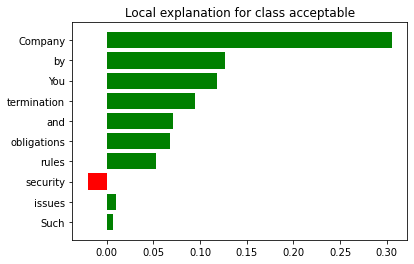

In [66]:
# generate Lime explanations for the first 100 predictions in the validation file
# these explanations take about 6 seconds each to generate, so it would take about 2 hours to general all the explanations
# any explanation can then be accessed with fig = exps[INDEX].as_pyplot_figure() as demonstrated above.

exps = []

for clause in tqdm(validation_texts[0:100]):
    exps.append(lime_explainer(clause)) 

PRODUCT Additional Terms of Service
Clause ID                 6937.000000
text_len                   872.000000
Prediction                   1.000000
Probability Acceptable       0.545086
Name: 54, dtype: float64


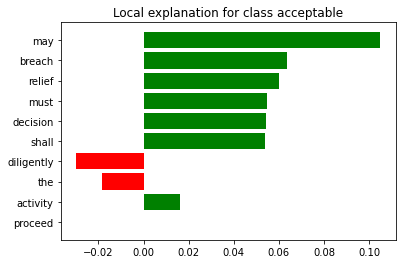

In [70]:
INDEX = 51
print(validation_texts[INDEX])
print(validation_df.iloc[INDEX])
fig = exps[INDEX].as_pyplot_figure()